1. Постановка задачи: Разработать систему для автоматического определения тональности (сентимента) отзывов пользователей на товары в интернет-магазине.
Такая система позволит автоматически анализировать тысячи отзывов без участия человека, выявлять проблемные товары по наплыву негативных отзывов, улучшать рейтинги товаров и повышать доверие покупателей, оперативно реагируя на критику, а также - собирать инсайты о том, что нравится или не нравится клиентам.

2. Постановка ML-задачи 
Это задача бинарной классификации текстов. Нам необходимо по тексту отзыва отнести его к одному из двух классов:
Класс 1 (Positive): Позитивный отзыв.
Класс 0 (Negative): Негативный отзыв.
Математически, мы строим модель f(text), которая для входного текста text predicts вероятность P(class=1 | text).

3. Набор данных
Для этой задачи идеально подходит набор данных "Amazon Product Reviews".
Будем использовать датасет с отзывами на электронные товары с Amazon.
Источник: Kaggle (например, "Amazon Fine Food Reviews").
Содержание: Набор данных содержит сотни тысяч отзывов с различными метаданными. 
Для нашей задачи нам понадобятся две ключевые колонки:
Text - текст отзыва.
Score - рейтинг товара от 1 до 5.
Будем преобразовать рейтинг в бинарную метку: отзывы с оценкой 4-5 считать позитивными (1), а с оценкой 1-2 - негативными (0). 

4. Выбор и обоснование метрики
Предлагаемые метрики: F1-мера (F1-Score) и Матрица ошибок (Confusion Matrix).
Обоснование:
Наш датасет, как и многие реальные данные, скорее всего, будет несбалансированным — позитивных отзывов в среднем больше, чем негативных.
В такой ситуации точность (Accuracy) может быть обманчивой (например, 90% точности, если просто предсказывать "позитивный" для всех отзывов, что бесполезно для бизнеса).
F1-мера является гармоническим средним между точностью (Precision) и полнотой (Recall). Она позволяет найти баланс между двумя критически важными для бизнеса аспектами:
Precision (Точность): Насколько мы уверены, что отзыв, который мы пометили как негативный, действительно негативный. Высокая точность нужна, чтобы служба поддержки не тратила время на ложные срабатывания.
Recall (Полнота): Какую долю от всех реально негативных отзывов мы смогли найти. Высокая полнота нужна, чтобы не упустить критические проблемы с товарами.
Матрица ошибок дает наглядное представление о том, где именно ошибается модель (ложноположительные vs ложноотрицательные срабатывания).

In [19]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализаций
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

# Загрузка данных
df = pd.read_csv('data/Reviews.csv')

In [5]:
# Просмотр первых записей
print("\n=== ПЕРВЫЕ 3 ЗАПИСИ ===")
display(df.head(3))


=== ПЕРВЫЕ 3 ЗАПИСИ ===


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
# Проверка типов данных и пропусков
print("\n=== ИНФОРМАЦИЯ О ДАННЫХ ===")
print(df.info())

#Cистема голосования "Был ли отзыв полезен?" на Amazon:
#HelpfulnessDenominator - Сколько всего людей увидели отзыв и могли проголосовать
#HelpfulnessNumerator - Сколько людей нажало "Да, этот отзыв полезен"

print("\n=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# %%
# Обработка пропусков
print("\n=== ОБРАБОТКА ПРОПУСКОВ ===")
print(f"Размер до удаления пропусков: {df.shape}")

# Удаляем строки с пропусками в ключевых колонках
df_clean = df.dropna(subset=['Text', 'Summary'])
print(f"Размер после удаления пропусков: {df_clean.shape}")



=== ИНФОРМАЦИЯ О ДАННЫХ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None

=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===
ProfileName    26
Summary        27
dtype: int64

=== ОБРАБОТКА ПРОПУСКОВ ===
Размер до удаления пропусков: (568454, 10)
Размер после удал

In [6]:
# Базовая информация о датасете
print("=== БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ ===")
print(f"Размер датасета: {df.shape}")
print(f"Количество отзывов: {df.shape[0]:,}")
print(f"Количество признаков: {df.shape[1]}")
print("\nКолонки в датасете:")
print(df.columns.tolist())

=== БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ ===
Размер датасета: (568454, 10)
Количество отзывов: 568,454
Количество признаков: 10

Колонки в датасете:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


In [7]:
# Создание целевой переменной (sentiment)
print("\n=== СОЗДАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")
# Score 4-5 -> Positive (1), Score 1-2 -> Negative (0), Score 3 -> Neutral (исключаем)
df_clean = df_clean[df_clean['Score'] != 3]  # Удаляем нейтральные отзывы
df_clean['sentiment'] = df_clean['Score'].apply(lambda x: 1 if x > 3 else 0)

print("Распределение оценок:")
print(df_clean['Score'].value_counts().sort_index())
print(f"\nРаспределение сентиментов:")
sentiment_counts = df_clean['sentiment'].value_counts()
print(sentiment_counts)
print(f"Доля позитивных отзывов: {df_clean['sentiment'].mean():.2%}")


=== СОЗДАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
Распределение оценок:
Score
1     52268
2     29744
4     80655
5    363122
Name: count, dtype: int64

Распределение сентиментов:
sentiment
1    443777
0     82012
Name: count, dtype: int64
Доля позитивных отзывов: 84.40%



=== ВИЗУАЛИЗАЦИЯ: РАСПРЕДЕЛЕНИЕ ОЦЕНОК ===


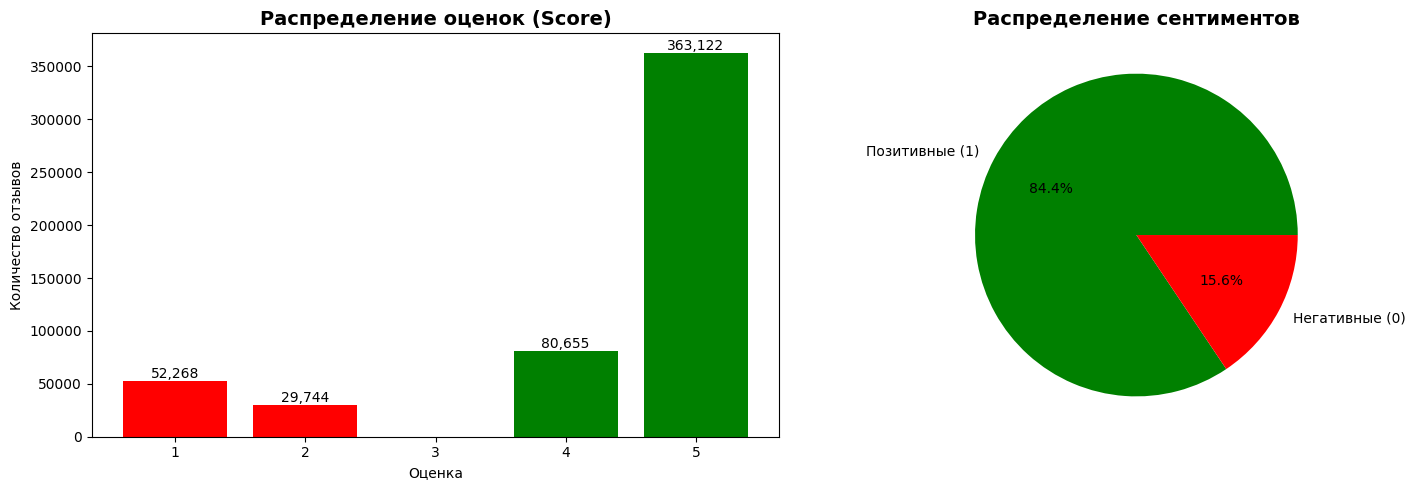

In [23]:
# Визуализация 1: Распределение оценок (Matplotlib)
print("\n=== ВИЗУАЛИЗАЦИЯ: РАСПРЕДЕЛЕНИЕ ОЦЕНОК ===")
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
score_dist = df_clean['Score'].value_counts().sort_index()
bars = plt.bar(score_dist.index, score_dist.values, color=['red', 'red', 'green', 'green'])
plt.title('Распределение оценок (Score)', fontsize=14, fontweight='bold')
plt.xlabel('Оценка')
plt.ylabel('Количество отзывов')
# Добавляем подписи значений
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:,}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
sentiment_dist = df_clean['sentiment'].value_counts()
colors = ['green','red']
plt.pie(sentiment_dist.values, labels=['Позитивные (1)', 'Негативные (0)'], autopct='%1.1f%%', colors=colors)
plt.title('Распределение сентиментов', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


=== ВИЗУАЛИЗАЦИЯ: ДЛИНА ТЕКСТА ===


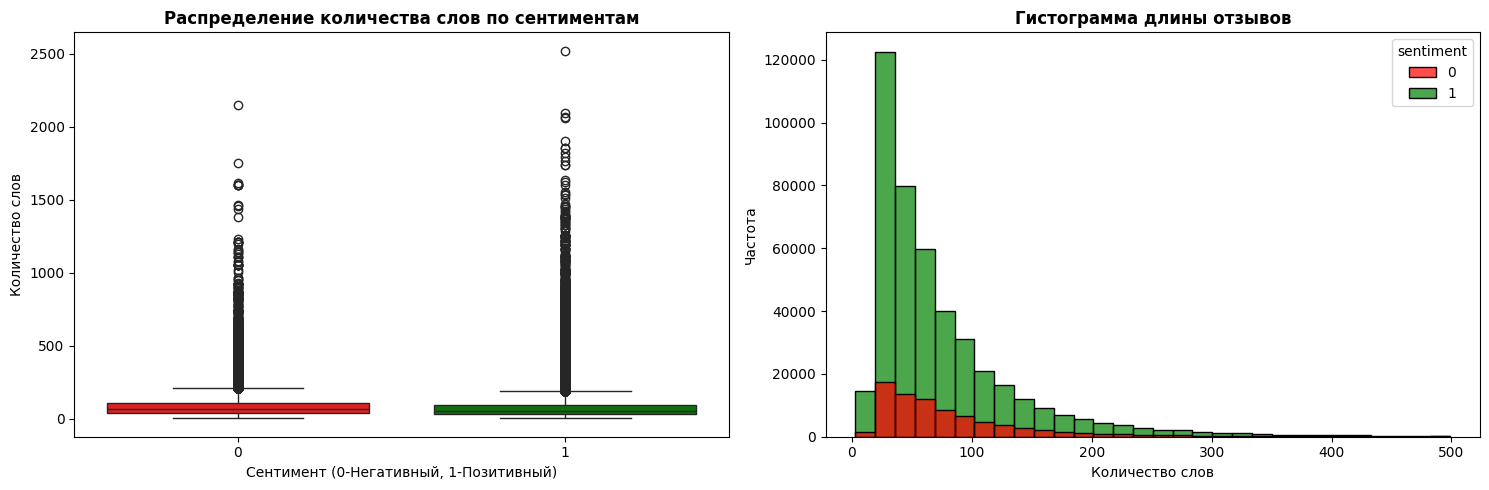


=== АНАЛИЗ ПОЛЕЗНОСТИ ОТЗЫВОВ ===
Средняя полезность по сентиментам:
sentiment
0    0.395346
1    0.415249
Name: helpfulness_ratio, dtype: float64


In [10]:
# Визуализация 2: Длина текста vs Сентимент
print("\n=== ВИЗУАЛИЗАЦИЯ: ДЛИНА ТЕКСТА ===")
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_clean, x='sentiment', y='word_count', palette=['red', 'green'])
plt.title('Распределение количества слов по сентиментам', fontweight='bold')
plt.xlabel('Сентимент (0-Негативный, 1-Позитивный)')
plt.ylabel('Количество слов')

plt.subplot(1, 2, 2)
# Ограничим выбросы для лучшей визуализации
df_filtered = df_clean[df_clean['word_count'] < 500]
sns.histplot(data=df_filtered, x='word_count', hue='sentiment', bins=30, alpha=0.7, palette=['red', 'green'])
plt.title('Гистограмма длины отзывов', fontweight='bold')
plt.xlabel('Количество слов')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# %%
# Анализ Helpfulness (полезности отзывов)
print("\n=== АНАЛИЗ ПОЛЕЗНОСТИ ОТЗЫВОВ ===")
df_clean['helpfulness_ratio'] = df_clean['HelpfulnessNumerator'] / df_clean['HelpfulnessDenominator']
df_clean['helpfulness_ratio'] = df_clean['helpfulness_ratio'].fillna(0)  # Заменяем NaN на 0

print("Средняя полезность по сентиментам:")
helpfulness_stats = df_clean.groupby('sentiment')['helpfulness_ratio'].mean()
print(helpfulness_stats)



=== ВИЗУАЛИЗАЦИЯ: ПОЛЕЗНОСТЬ ОТЗЫВОВ ===


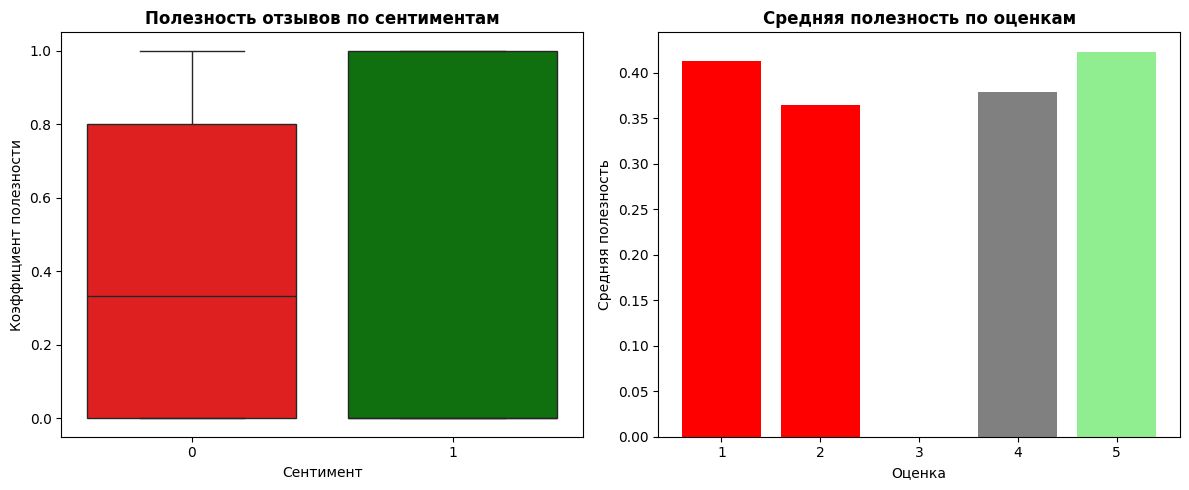


=== АНАЛИЗ ВРЕМЕННЫХ МЕТОК ===
Годы отзывов:
year
1999         6
2000        32
2001        12
2002        73
2003       124
2004       543
2005      1282
2006      6243
2007     20949
2008     31992
2009     51564
2010     79636
2011    150277
2012    183056
Name: count, dtype: int64


In [11]:
# Визуализация 3: Полезность отзывов
print("\n=== ВИЗУАЛИЗАЦИЯ: ПОЛЕЗНОСТЬ ОТЗЫВОВ ===")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_clean[df_clean['helpfulness_ratio'] <= 1], 
            x='sentiment', y='helpfulness_ratio', palette=['red', 'green'])
plt.title('Полезность отзывов по сентиментам', fontweight='bold')
plt.xlabel('Сентимент')
plt.ylabel('Коэффициент полезности')

plt.subplot(1, 2, 2)
helpful_by_score = df_clean.groupby('Score')['helpfulness_ratio'].mean()
plt.bar(helpful_by_score.index, helpful_by_score.values, 
        color=['red', 'red', 'gray', 'lightgreen', 'darkgreen'])
plt.title('Средняя полезность по оценкам', fontweight='bold')
plt.xlabel('Оценка')
plt.ylabel('Средняя полезность')

plt.tight_layout()
plt.show()

# %%
# Анализ временных меток
print("\n=== АНАЛИЗ ВРЕМЕННЫХ МЕТОК ===")
# Конвертируем Unix time в datetime
df_clean['datetime'] = pd.to_datetime(df_clean['Time'], unit='s')
df_clean['year'] = df_clean['datetime'].dt.year
df_clean['month'] = df_clean['datetime'].dt.month

print("Годы отзывов:")
print(df_clean['year'].value_counts().sort_index())



=== ВИЗУАЛИЗАЦИЯ: РАСПРЕДЕЛЕНИЕ ПО ВРЕМЕНИ ===


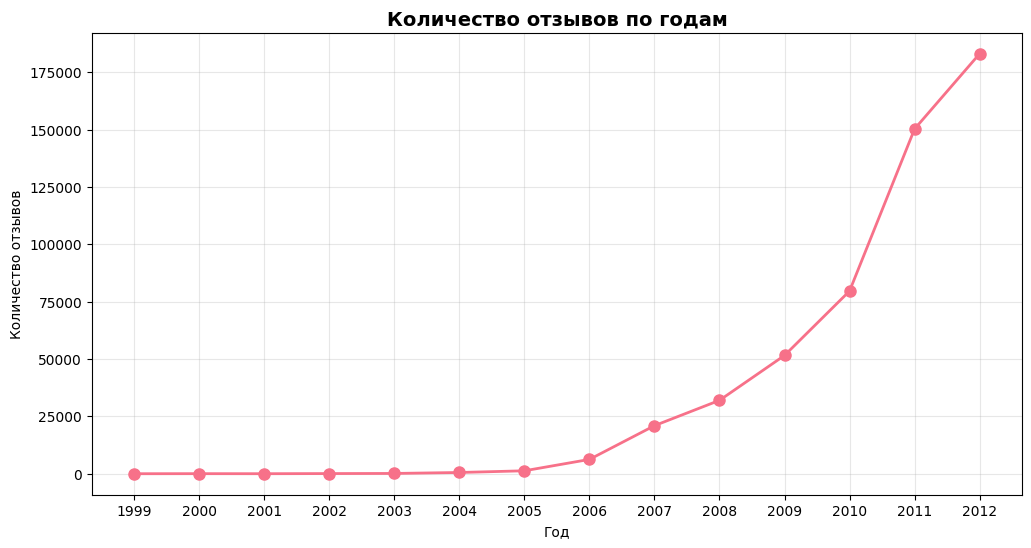

In [12]:
# Визуализация 4: Распределение отзывов по времени
print("\n=== ВИЗУАЛИЗАЦИЯ: РАСПРЕДЕЛЕНИЕ ПО ВРЕМЕНИ ===")
reviews_by_year = df_clean['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(reviews_by_year.index, reviews_by_year.values, marker='o', linewidth=2, markersize=8)
plt.title('Количество отзывов по годам', fontsize=14, fontweight='bold')
plt.xlabel('Год')
plt.ylabel('Количество отзывов')
plt.grid(True, alpha=0.3)
plt.xticks(reviews_by_year.index)
plt.show()

In [14]:
# Анализ самых активных пользователей и продуктов
print("\n=== АНАЛИЗ АКТИВНОСТИ ===")

top_users = df_clean['UserId'].value_counts().head(10)
top_products = df_clean['ProductId'].value_counts().head(10)

print("Топ-10 самых активных пользователей:")
print(top_users)

print("\nТоп-10 самых рецензируемых продуктов:")
print(top_products)



=== АНАЛИЗ АКТИВНОСТИ ===
Топ-10 самых активных пользователей:
UserId
A3OXHLG6DIBRW8    425
A1YUL9PCJR3JTY    391
AY12DBB0U420B     365
A281NPSIMI1C2R    346
A1Z54EM24Y40LL    230
A3TVZM3ZIXG8YW    199
A1TMAVN4CEM8U8    196
A3PJZ8TU8FDQ1K    173
A29JUMRL1US6YP    171
A2MUGFV2TDQ47K    161
Name: count, dtype: int64

Топ-10 самых рецензируемых продуктов:
ProductId
B007JFMH8M    857
B0026RQTGE    611
B002QWP89S    611
B002QWP8H0    611
B002QWHJOU    611
B003B3OOPA    598
B001EO5Q64    552
B000NMJWZO    533
B001RVFEP2    518
B007M832YY    518
Name: count, dtype: int64



=== ВИЗУАЛИЗАЦИЯ: ТОП ПРОДУКТЫ ===


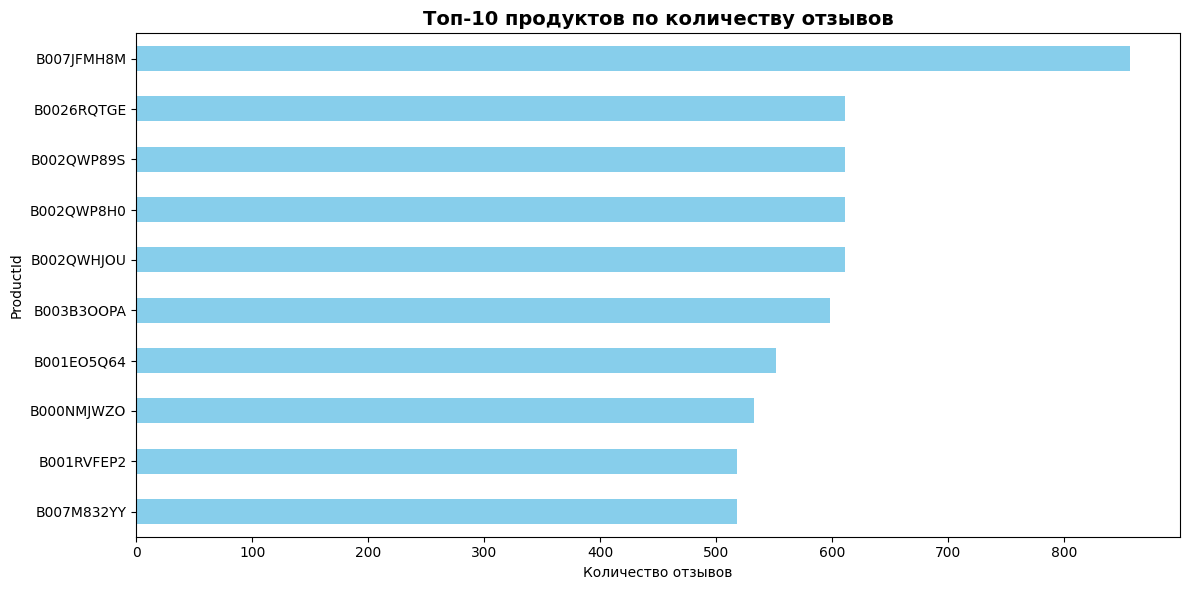

In [15]:
# Визуализация 5: Топ продукты по количеству отзывов
print("\n=== ВИЗУАЛИЗАЦИЯ: ТОП ПРОДУКТЫ ===")
plt.figure(figsize=(12, 6))
top_products.head(10).plot(kind='barh', color='skyblue')
plt.title('Топ-10 продуктов по количеству отзывов', fontsize=14, fontweight='bold')
plt.xlabel('Количество отзывов')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ===


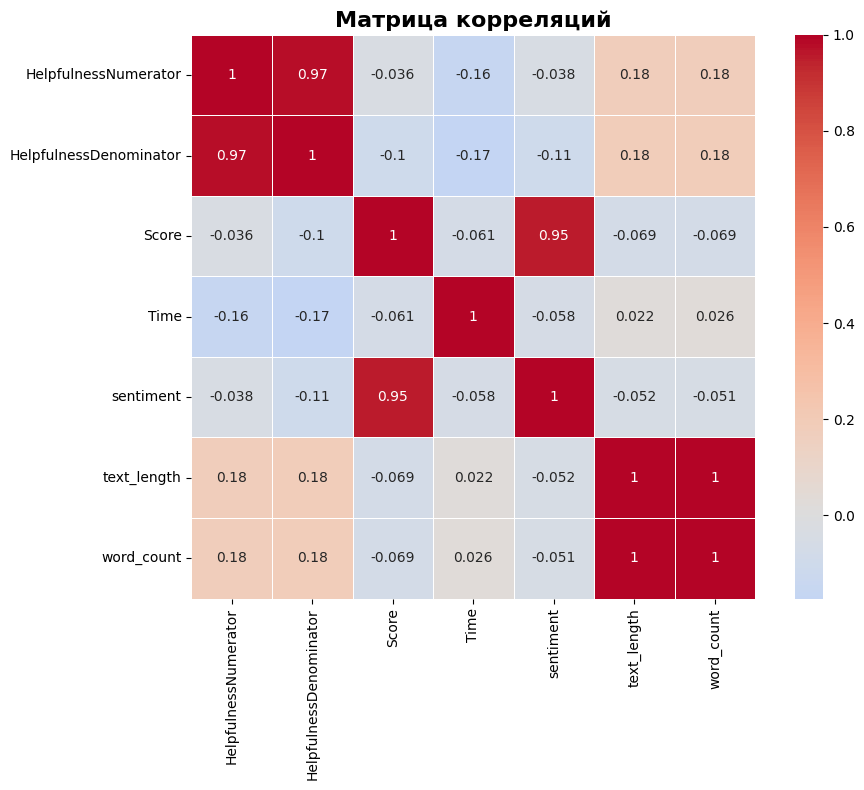

In [16]:
# Корреляционный анализ
print("\n=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ===")
numeric_cols = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'sentiment', 'text_length', 'word_count']
correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Матрица корреляций', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
# Статистики по тексту
print("\n=== СТАТИСТИКИ ПО ТЕКСТУ ===")
text_stats = df_clean.groupby('sentiment').agg({
    'word_count': ['mean', 'median', 'std', 'min', 'max'],
    'text_length': ['mean', 'median', 'std']
}).round(2)

print("Статистики длины текста по сентиментам:")
print(text_stats)

# %%
# Анализ выбросов в длине текста
print("\n=== АНАЛИЗ ВЫБРОСОВ ===")
Q1 = df_clean['word_count'].quantile(0.25)
Q3 = df_clean['word_count'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_clean[(df_clean['word_count'] < (Q1 - 1.5 * IQR)) | 
                    (df_clean['word_count'] > (Q3 + 1.5 * IQR))]

print(f"Количество выбросов в длине текста: {len(outliers)} ({len(outliers)/len(df_clean):.2%})")


=== СТАТИСТИКИ ПО ТЕКСТУ ===
Статистики длины текста по сентиментам:
          word_count                         text_length               
                mean median    std min   max        mean median     std
sentiment                                                              
0              88.33   64.0  89.08   3  2149      482.75  345.0  498.73
1              77.30   54.0  76.20   3  2520      419.56  288.0  426.53

=== АНАЛИЗ ВЫБРОСОВ ===
Количество выбросов в длине текста: 34915 (6.64%)
